<a href="https://colab.research.google.com/github/MargareV/VAE-for-de-novo-drug-design/blob/master/chemceptionVAE_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-11-29 14:21:02--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   142MB/s    in 0.5s    

2019-11-29 14:21:03 (142 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_

In [3]:
!pip install tensorflow --upgrade

     |████████████████████████████████| 86.3MB 117kB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 112kB 47.0MB/s 
     |████████████████████████████████| 1.3MB 40.7MB/s 
     |████████████████████████████████| 450kB 26.7MB/s 
     |████████████████████████████████| 2.4MB 39.5MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 3.8MB 40.9MB/s 
     |████████████████████████████████| 2.9MB 41.0MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 327kB 42.2MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 133kB 45.0MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 153kB 45.2MB/s 
  Created wheel for wrapt: filename=wrapt-1.11.2-cp37-cp37m-l

In [4]:
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import keras
#from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ReduceLROnPlateau
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from datetime import datetime

Using TensorFlow backend.


In [0]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy] = bondorder
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy] = atom.GetAtomicNum()
    #Atom Layers
#    for i,atom in enumerate(cmol.GetAtoms()):
#            idx = int(round((coords[i][0] + embed)/res))
#            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
#            vect[ idx , idy, 1] = 0
            #Gasteiger Charges
#            charge = atom.GetProp("_GasteigerCharge")
#            vect[ idx , idy, 2] = 0
            #Hybridization
#            hyptype = atom.GetHybridization().real
#            vect[ idx , idy, 2] = hyptype
    return vect

In [6]:
print("Keras: %s"%keras.__version__)
print("RDKit: %s"%rdkit.__version__)

data = pd.read_csv('/content/drive/My Drive/Images_zinc/smiles_zinc.csv', skip_blank_lines=True, nrows=25000, usecols=[0])
data["mol"] = data["smiles"].apply(Chem.MolFromSmiles)
print(data.shape)

def vectorize(mol):
    return chemcepterize_mol(mol, embed=20)
data["molimage"] = data["mol"].apply(vectorize)
print(data.shape)
final_data = np.array(list(data["molimage"]))
print(final_data.shape)
x_test = final_data[20000:25000, ]
x_train = final_data[0:20000, ]

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

Keras: 2.2.5
RDKit: 2019.09.1
(25000, 2)
(25000, 3)
(25000, 80, 80)
(20000, 6400)
(5000, 6400)


In [0]:
batch_size = 8
image_size = x_train.shape[1]
original_dim = image_size
intermediate_dim = 3200
latent_dim = 15
epochs = 150


In [8]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim)) # for random_normal, mean=0. and std=1.
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

def vae_loss(x, x_decoded_mean):
    xent_loss = metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (8, 6400)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (8, 3200)            20483200    input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (8, 15)              48015       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (8, 15)              48015       dense_1[0][0]             

In [9]:
history = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        )
print(history.history.keys())




Train on 20000 samples, validate on 5000 samples
Epoch 1/150





20000/20000 [==============================] - 100s 5ms/step - loss: 0.0026 - val_loss: 9.7693e-04
Epoch 2/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7526e-04 - val_loss: 9.7484e-04
Epoch 3/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7475e-04 - val_loss: 9.7429e-04
Epoch 4/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7453e-04 - val_loss: 9.7576e-04
Epoch 5/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7423e-04 - val_loss: 9.7563e-04
Epoch 6/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7410e-04 - val_loss: 9.7385e-04
Epoch 7/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7399e-04 - val_loss: 9.7408e-04
Epoch 8/150
20000/20000 [==============================] - 95s 5ms/step - loss: 9.7377e-04 - val_loss: 9.7385e-04
Epoch 9/150
20000/20000 [=========

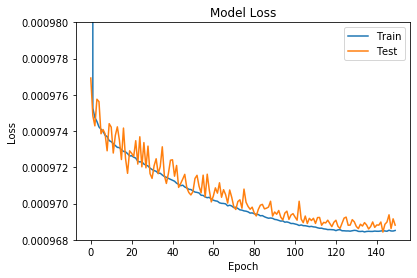

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], )
plt.axis(ymin=0.000968, ymax=0.00098)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()